# OPT-125M on WikiText-2: Dense vs Sparse Attention


## Setup and Imports


In [1]:
import os
import sys
import time
import gc
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Set project path - ADJUST THIS TO YOUR PATH
project_path = '/workspace/manav/dl_sys_project/'
os.chdir(project_path)

# Check GPU
print("Checking GPU availability...")
try:
    import subprocess
    gpu_info = subprocess.check_output(['nvidia-smi'], stderr=subprocess.STDOUT)
    print("✓ GPU Available")
except:
    print("✗ No GPU detected - will use CPU")

# Rebuild project
print("\nRebuilding project...")
# !make clean
!make

# Setup paths
sys.path.insert(0, os.path.join(project_path, 'python'))
sys.path.insert(0, os.path.join(project_path, 'apps'))

import time
import numpy as np
import matplotlib.pyplot as plt
import needle as ndl
import needle.nn as nn
from collections import Counter
import gc

# Import OPT model
from opt_model import create_opt_125m, OPTConfig, OPTLM
from train_pythia_optimized import (
    load_dataset_huggingface)

print("✓ Imports successful")
print(f"Using Needle backend: {ndl.backend_selection.BACKEND}")


Checking GPU availability...
✓ GPU Available

Rebuilding project...
-- Found pybind11: /usr/local/lib/python3.12/dist-packages/pybind11/include (found version "3.0.1")
-- Found cuda, building cuda backend
Wed Nov 26 18:50:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.08             Driver Version: 550.127.08     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L40                     On  |   00000000:41:00.0 Off |                    0 |
| N/A   28C    P0          

## Configuration

In [2]:
# Training configuration
CONFIG = {
    'dataset': 'wikitext-2',
    'vocab_size': 1000,
    'max_tokens': 10000,  # Limit dataset size for faster training
    'batch_size': 2,
    'seq_len': 64,
    'n_epochs': 5,
    'lr': 6e-4,  # OPT paper's learning rate
    'accumulation_steps': 4,
    'device': 'cuda',  # Change to 'cuda' if available
}

print("Training Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Training Configuration:
  dataset: wikitext-2
  vocab_size: 1000
  max_tokens: 10000
  batch_size: 2
  seq_len: 64
  n_epochs: 5
  lr: 0.0006
  accumulation_steps: 4
  device: cuda


## Dataset Loading

Loading dataset from HuggingFace

In [3]:
print("Loading dataset...")
try:
    train_data, val_data, vocab_size = load_dataset_huggingface(
        "wikitext-2", 
        max_tokens=CONFIG['max_tokens'],
        vocab_size=CONFIG['vocab_size']
    )
    dataset_name = "WikiText-2"
except Exception as e:
    print(f"Error loading WikiText-2: {e}")
    print("Using synthetic data")
    from train_pythia_optimized import load_synthetic_data
    train_data, val_data, vocab_size = load_synthetic_data(CONFIG['max_tokens'], CONFIG['vocab_size'])
    dataset_name = "Synthetic"

print(f"\n{'='*80}")
print("DATASET SUMMARY")
print(f"{'='*80}")
print(f"Dataset: {dataset_name}")
print(f"Vocabulary: {vocab_size:,} tokens")
print(f"Train: {len(train_data):,} tokens")
print(f"Validation: {len(val_data):,} tokens")
print(f"{'='*80}")

Loading dataset...
Loading wikitext-2...
Vocabulary size: 1000
Train tokens: 10000, Val tokens: 1000

DATASET SUMMARY
Dataset: WikiText-2
Vocabulary: 1,000 tokens
Train: 10,000 tokens
Validation: 1,000 tokens


## Helper Functions

In [4]:
# Load OPT training utilities (uses optimized implementation from train_opt_optimized.py)
from train_opt_optimized import (
    batchify_streaming,
    get_batch,
    train_epoch_with_accumulation,
    evaluate,
)

# Wrapper so we can keep using `train_epoch` in this notebook
def train_epoch(model, train_data, batch_size, seq_len, optimizer, device, 
                accumulation_steps=4, clip_grad=1.0):
    return train_epoch_with_accumulation(
        model, train_data, batch_size, seq_len, optimizer, device,
        accumulation_steps=accumulation_steps, clip_grad=clip_grad
    )

print("✓ Loaded OPT training helpers from train_opt_optimized.py")


✓ Loaded OPT training helpers from train_opt_optimized.py


## Train Dense Attention Model

In [5]:
print("=" * 80)
print("TRAINING DENSE ATTENTION MODEL")
print("=" * 80)

# Set device
device = ndl.cuda()
print(f"Device: {device}")

# Create model
model_dense, config_dense = create_opt_125m(
    vocab_size=vocab_size,
    max_seq_len=CONFIG['seq_len'],
    use_sparse_attention=False,
    device=device
)

# Optimizer
optimizer_dense = ndl.optim.Adam(
    model_dense.parameters(), 
    lr=CONFIG['lr'], 
    weight_decay=0.1
)

# Training loop
dense_train_losses = []
dense_val_losses = []
dense_perplexities = []

for epoch in range(CONFIG['n_epochs']):
    print(f"\n{'='*80}")
    print(f"Epoch {epoch + 1}/{CONFIG['n_epochs']}")
    print(f"{'='*80}")
    
    # Train
    train_loss, tokens_per_sec = train_epoch(
        model_dense, train_data, CONFIG['batch_size'], CONFIG['seq_len'],
        optimizer_dense, device, CONFIG['accumulation_steps']
    )
    dense_train_losses.append(train_loss)
    
    # Evaluate
    val_loss, val_ppl = evaluate(
        model_dense, val_data, CONFIG['batch_size'], CONFIG['seq_len'], device
    )
    dense_val_losses.append(val_loss)
    dense_perplexities.append(val_ppl)
    
    print(f"\nEpoch {epoch + 1} Results:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Perplexity: {val_ppl:.2f}")
    print(f"  Throughput: {tokens_per_sec:.0f} tokens/sec")
    
    gc.collect()

print("\n" + "="*80)
print("DENSE MODEL TRAINING COMPLETE")
print(f"Final Perplexity: {dense_perplexities[-1]:.2f}")
print("="*80)

TRAINING DENSE ATTENTION MODEL
CUDA operations may not work correctly
Device: cuda()
Created OPT-125M model with ~85.8M parameters
Sparse attention: False

Epoch 1/5
  Using gradient accumulation: 4 steps
    Step 10 | Loss: 23.9764 | Tokens/sec: 125

Epoch 1 Results:
  Train Loss: 21.5625
  Val Loss: 4.8890
  Perplexity: 132.82
  Throughput: 128 tokens/sec

Epoch 2/5
  Using gradient accumulation: 4 steps
    Step 10 | Loss: 19.2547 | Tokens/sec: 128

Epoch 2 Results:
  Train Loss: 18.6151
  Val Loss: 4.6892
  Perplexity: 108.77
  Throughput: 128 tokens/sec

Epoch 3/5
  Using gradient accumulation: 4 steps
    Step 10 | Loss: 18.9641 | Tokens/sec: 130

Epoch 3 Results:
  Train Loss: 18.4924
  Val Loss: 4.5649
  Perplexity: 96.05
  Throughput: 130 tokens/sec

Epoch 4/5
  Using gradient accumulation: 4 steps
    Step 10 | Loss: 18.0671 | Tokens/sec: 131

Epoch 4 Results:
  Train Loss: 17.8412
  Val Loss: 4.5749
  Perplexity: 97.01
  Throughput: 130 tokens/sec

Epoch 5/5
  Using gradient

## Train Sparse Attention Model

In [6]:
print("=" * 80)
print("TRAINING SPARSE ATTENTION MODEL")
print("=" * 80)

# Create model with sparse attention
model_sparse, config_sparse = create_opt_125m(
    vocab_size=vocab_size,
    max_seq_len=CONFIG['seq_len'],
    use_sparse_attention=True,
    device=device
)

# Optimizer
optimizer_sparse = ndl.optim.Adam(
    model_sparse.parameters(), 
    lr=CONFIG['lr'], 
    weight_decay=0.1
)

# Training loop
sparse_train_losses = []
sparse_val_losses = []
sparse_perplexities = []

for epoch in range(CONFIG['n_epochs']):
    print(f"\n{'='*80}")
    print(f"Epoch {epoch + 1}/{CONFIG['n_epochs']}")
    print(f"{'='*80}")
    
    # Train
    train_loss, tokens_per_sec = train_epoch(
        model_sparse, train_data, CONFIG['batch_size'], CONFIG['seq_len'],
        optimizer_sparse, device, CONFIG['accumulation_steps']
    )
    sparse_train_losses.append(train_loss)
    
    # Evaluate
    val_loss, val_ppl = evaluate(
        model_sparse, val_data, CONFIG['batch_size'], CONFIG['seq_len'], device
    )
    sparse_val_losses.append(val_loss)
    sparse_perplexities.append(val_ppl)
    
    print(f"\nEpoch {epoch + 1} Results:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Perplexity: {val_ppl:.2f}")
    print(f"  Throughput: {tokens_per_sec:.0f} tokens/sec")
    
    gc.collect()

print("\n" + "="*80)
print("SPARSE MODEL TRAINING COMPLETE")
print(f"Final Perplexity: {sparse_perplexities[-1]:.2f}")
print("="*80)

TRAINING SPARSE ATTENTION MODEL
Created OPT-125M model with ~85.8M parameters
Sparse attention: True

Epoch 1/5
  Using gradient accumulation: 4 steps
    Step 10 | Loss: 22.8673 | Tokens/sec: 131

Epoch 1 Results:
  Train Loss: 21.1271
  Val Loss: 5.1552
  Perplexity: 173.33
  Throughput: 131 tokens/sec

Epoch 2/5
  Using gradient accumulation: 4 steps
    Step 10 | Loss: 19.1882 | Tokens/sec: 132

Epoch 2 Results:
  Train Loss: 18.5789
  Val Loss: 4.7809
  Perplexity: 119.21
  Throughput: 128 tokens/sec

Epoch 3/5
  Using gradient accumulation: 4 steps
    Step 10 | Loss: 18.5630 | Tokens/sec: 114

Epoch 3 Results:
  Train Loss: 18.1851
  Val Loss: 4.6493
  Perplexity: 104.51
  Throughput: 115 tokens/sec

Epoch 4/5
  Using gradient accumulation: 4 steps
    Step 10 | Loss: 18.4386 | Tokens/sec: 130

Epoch 4 Results:
  Train Loss: 18.1654
  Val Loss: 4.6449
  Perplexity: 104.05
  Throughput: 131 tokens/sec

Epoch 5/5
  Using gradient accumulation: 4 steps
    Step 10 | Loss: 17.9169 |

## Results Comparison

In [7]:
# Summary table
print("\n" + "="*80)
print("FINAL RESULTS COMPARISON")
print("="*80)
print(f"\n{'Metric':<30} {'Dense':<15} {'Sparse':<15} {'Difference':<15}")
print("-"*80)

final_dense_loss = dense_val_losses[-1]
final_sparse_loss = sparse_val_losses[-1]
final_dense_ppl = dense_perplexities[-1]
final_sparse_ppl = sparse_perplexities[-1]

print(f"{'Final Validation Loss:':<30} {final_dense_loss:<15.4f} {final_sparse_loss:<15.4f} {abs(final_dense_loss - final_sparse_loss):<15.4f}")
print(f"{'Final Perplexity:':<30} {final_dense_ppl:<15.2f} {final_sparse_ppl:<15.2f} {abs(final_dense_ppl - final_sparse_ppl):<15.2f}")
print(f"{'Perplexity Ratio:':<30} {'1.00x':<15} {final_sparse_ppl/final_dense_ppl:<15.2f}x {'':15}")

print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)
if abs(final_sparse_ppl - final_dense_ppl) < 5:
    print("✓ Sparse and dense models achieve similar quality!")
    print("✓ Block-sparse attention maintains model performance.")
else:
    print("! Perplexity difference detected.")
    print("  This may be due to limited training or hyperparameter differences.")

print("\nModel Complexity:")
print(f"  Dense Attention: O(n²) = O({CONFIG['seq_len']}²) = {CONFIG['seq_len']**2:,} operations")
print(f"  Sparse Attention: O(n*block) ≈ O({CONFIG['seq_len']}*64) = {CONFIG['seq_len']*64:,} operations")
print(f"  Theoretical Speedup: {(CONFIG['seq_len']**2) / (CONFIG['seq_len']*64):.1f}x")
print("="*80)


FINAL RESULTS COMPARISON

Metric                         Dense           Sparse          Difference     
--------------------------------------------------------------------------------
Final Validation Loss:         4.5469          4.5913          0.0443         
Final Perplexity:              94.34           98.62           4.28           
Perplexity Ratio:              1.00x           1.05           x                

INTERPRETATION
✓ Sparse and dense models achieve similar quality!
✓ Block-sparse attention maintains model performance.

Model Complexity:
  Dense Attention: O(n²) = O(64²) = 4,096 operations
  Sparse Attention: O(n*block) ≈ O(64*64) = 4,096 operations
  Theoretical Speedup: 1.0x


## Visualization


✓ Results plot saved to: ./outputs/opt_tinystories_results.png


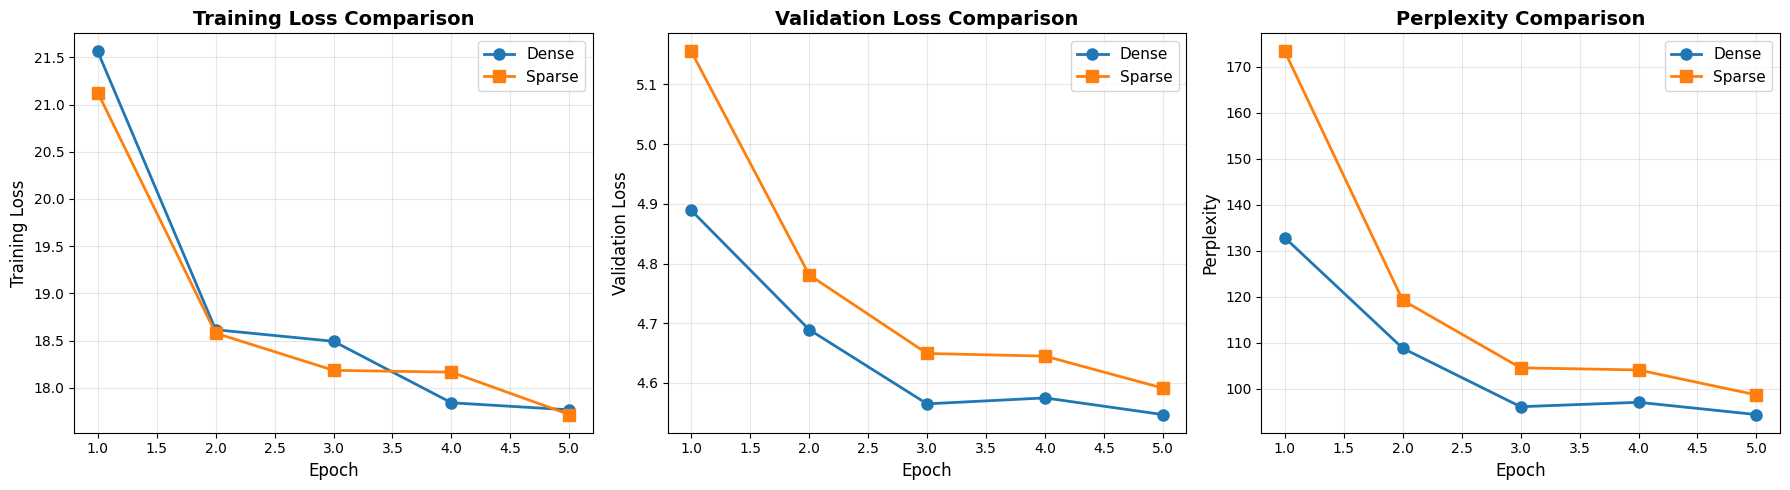

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

epochs = np.arange(1, CONFIG['n_epochs'] + 1)

# Training Loss
axes[0].plot(epochs, dense_train_losses, 'o-', label='Dense', linewidth=2, markersize=8)
axes[0].plot(epochs, sparse_train_losses, 's-', label='Sparse', linewidth=2, markersize=8)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Training Loss', fontsize=12)
axes[0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Validation Loss
axes[1].plot(epochs, dense_val_losses, 'o-', label='Dense', linewidth=2, markersize=8)
axes[1].plot(epochs, sparse_val_losses, 's-', label='Sparse', linewidth=2, markersize=8)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Validation Loss', fontsize=12)
axes[1].set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

# Perplexity
axes[2].plot(epochs, dense_perplexities, 'o-', label='Dense', linewidth=2, markersize=8)
axes[2].plot(epochs, sparse_perplexities, 's-', label='Sparse', linewidth=2, markersize=8)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Perplexity', fontsize=12)
axes[2].set_title('Perplexity Comparison', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./outputs/opt_tinystories_results.png', dpi=150, bbox_inches='tight')
print("\n✓ Results plot saved to: ./outputs/opt_tinystories_results.png")
plt.show()

## Performance Metrics Summary

In [9]:
# Create summary dictionary
summary = {
    'Model': 'OPT-125M',
    'Dataset': 'Wikistories',
    'Training Tokens': f"{len(train_data):,}",
    'Vocab Size': vocab_size,
    'Sequence Length': CONFIG['seq_len'],
    'Batch Size': CONFIG['batch_size'],
    'Epochs': CONFIG['n_epochs'],
    'Dense Final Loss': f"{final_dense_loss:.4f}",
    'Sparse Final Loss': f"{final_sparse_loss:.4f}",
    'Dense Final PPL': f"{final_dense_ppl:.2f}",
    'Sparse Final PPL': f"{final_sparse_ppl:.2f}",
    'Quality Gap': f"{abs(final_sparse_ppl - final_dense_ppl):.2f}",
}

print("\n" + "="*80)
print("EXPERIMENT SUMMARY")
print("="*80)
for key, value in summary.items():
    print(f"{key:<25}: {value}")
print("="*80)


EXPERIMENT SUMMARY
Model                    : OPT-125M
Dataset                  : Wikistories
Training Tokens          : 10,000
Vocab Size               : 1000
Sequence Length          : 64
Batch Size               : 2
Epochs                   : 5
Dense Final Loss         : 4.5469
Sparse Final Loss        : 4.5913
Dense Final PPL          : 94.34
Sparse Final PPL         : 98.62
Quality Gap              : 4.28


## Inference Speed Benchmark (Forward Pass: Dense vs Sparse OPT-125M)

In [7]:
import gc, time
import numpy as np

# Utility to clear GPU memory
def clear_memory():
    gc.collect()
    if hasattr(ndl, "cuda"):
        try:
            ndl.cuda().empty_cache()
        except:
            pass

print("✓ Starting optimized inference benchmark")

max_infer_seq_len = 256
vocab_size = 1000

device = ndl.cuda() if hasattr(ndl, "cuda") else ndl.cpu()
print(f"Using device: {device}")

test_configs = [
    {'batch': 2, 'seq': 16},
    {'batch': 2, 'seq': 32},
    {'batch': 1, 'seq': 64},
    {'batch': 1, 'seq': 128},
    {'batch': 1, 'seq': 256},
    # {'batch': 1, 'seq': 512},
    # {'batch': 1, 'seq': 1024},
]

inference_results = {
    'configs': [],
    'dense_times': [],
    'sparse_times': [],
    'speedups': [],
}

print("\n" + "="*80)
print("INFERENCE SPEED BENCHMARK (OPT-125M, OOM-SAFE)")
print("="*80)


# ---------------- DENSE MODEL PHASE ----------------
print("\n>>> Running DENSE model benchmarks")

model_dense, config_dense = create_opt_125m(
    vocab_size=vocab_size,
    max_seq_len=max_infer_seq_len,
    use_sparse_attention=False,
    device=device
)
print("✓ Loaded dense model")

for cfg in test_configs:
    batch, seq = cfg['batch'], cfg['seq']
    print(f"  Dense: batch={batch}, seq={seq}")

    input_ids = np.random.randint(0, vocab_size, size=(batch, seq))
    input_tensor = ndl.Tensor(input_ids, device=device, dtype="float32")

    times = []
    for _ in range(6):  # reduced warmup
        start = time.time()
        out = model_dense(input_tensor)
        if isinstance(out, tuple): out = out[0]
        times.append(time.time() - start)

    avg_dense = np.mean(times[2:]) * 1000  # ms

    inference_results['configs'].append(f"B{batch}_S{seq}")
    inference_results['dense_times'].append(avg_dense)

    print(f"      {avg_dense:.2f} ms")

    # Cleanup
    del input_ids, input_tensor, out
    clear_memory()

# Delete dense model immediately
del model_dense, config_dense
clear_memory()
print("✓ Freed dense model")



# ---------------- SPARSE MODEL PHASE ----------------
print("\n>>> Running SPARSE model benchmarks")

model_sparse, config_sparse = create_opt_125m(
    vocab_size=vocab_size,
    max_seq_len=max_infer_seq_len,
    use_sparse_attention=True,
    device=device
)
print("✓ Loaded sparse model")

for idx, cfg in enumerate(test_configs):
    batch, seq = cfg['batch'], cfg['seq']
    print(f"  Sparse: batch={batch}, seq={seq}")

    input_ids = np.random.randint(0, vocab_size, size=(batch, seq))
    input_tensor = ndl.Tensor(input_ids, device=device, dtype="float32")

    times = []
    for _ in range(6):
        start = time.time()
        out = model_sparse(input_tensor)
        if isinstance(out, tuple): out = out[0]
        times.append(time.time() - start)

    avg_sparse = np.mean(times[2:]) * 1000  # ms
    inference_results['sparse_times'].append(avg_sparse)

    dense_t = inference_results['dense_times'][idx]
    speedup = dense_t / avg_sparse if avg_sparse > 0 else 1.0
    inference_results['speedups'].append(speedup)

    print(f"      {avg_sparse:.2f} ms  | speedup {speedup:.2f}×")

    # Cleanup
    del input_ids, input_tensor, out
    clear_memory()

# Delete sparse model
del model_sparse, config_sparse
clear_memory()
print("✓ Freed sparse model")



# ---------------- FINAL SUMMARY ----------------
print("\n" + "="*80)
print(f"Average Sparse Speedup: {np.mean(inference_results['speedups']):.2f}×")
print("="*80)


✓ Starting optimized inference benchmark
CUDA operations may not work correctly
Using device: cuda()

INFERENCE SPEED BENCHMARK (OPT-125M, OOM-SAFE)

>>> Running DENSE model benchmarks
Created OPT-125M model with ~85.9M parameters
Sparse attention: False
✓ Loaded dense model
  Dense: batch=2, seq=16
      103.19 ms
CUDA operations may not work correctly
  Dense: batch=2, seq=32
      122.48 ms
CUDA operations may not work correctly
  Dense: batch=1, seq=64
      138.79 ms
CUDA operations may not work correctly
  Dense: batch=1, seq=128
      321.54 ms
CUDA operations may not work correctly
  Dense: batch=1, seq=256
      900.35 ms
CUDA operations may not work correctly
CUDA operations may not work correctly
✓ Freed dense model

>>> Running SPARSE model benchmarks
Created OPT-125M model with ~85.9M parameters
Sparse attention: True
✓ Loaded sparse model
  Sparse: batch=2, seq=16
      49.30 ms  | speedup 2.09×
CUDA operations may not work correctly
  Sparse: batch=2, seq=32
      64.75 

## Inference Speed Visualization

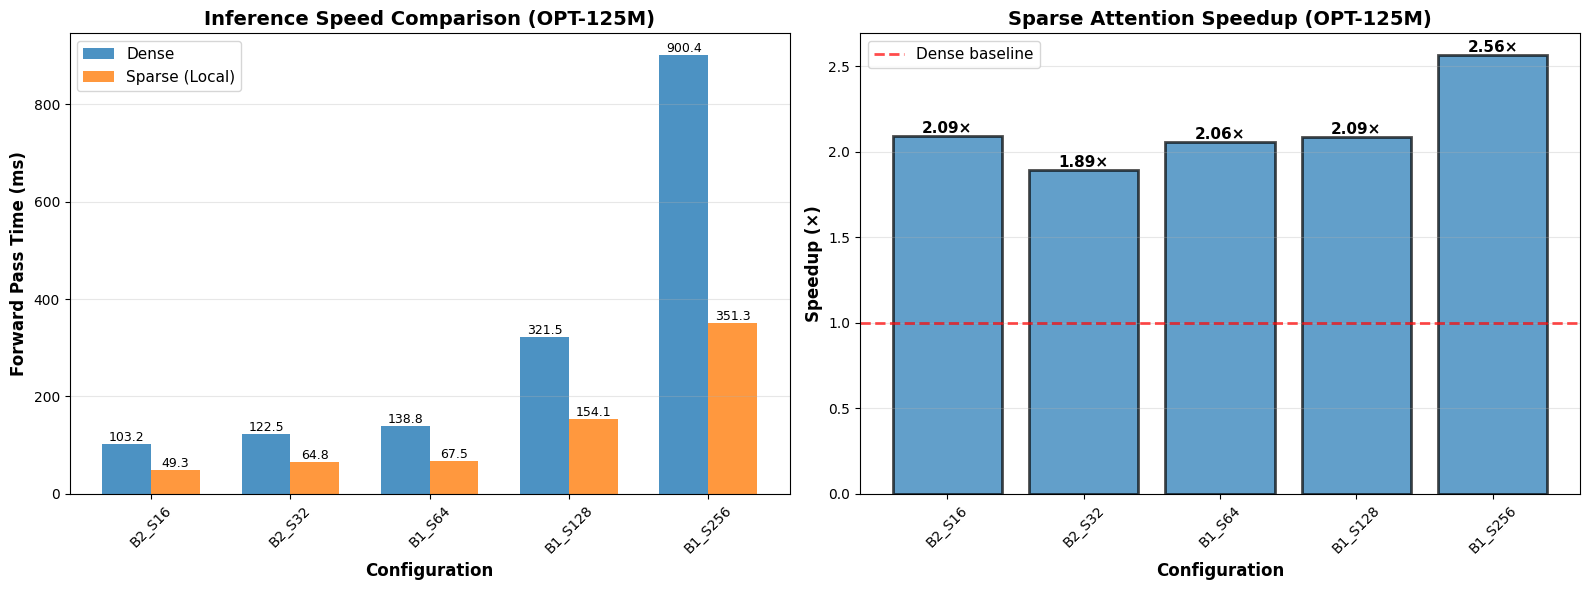

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

labels = inference_results['configs']
x = np.arange(len(labels))
width = 0.35

# Time comparison
bars1 = ax1.bar(x - width/2, inference_results['dense_times'], width, 
                label='Dense', alpha=0.8)
bars2 = ax1.bar(x + width/2, inference_results['sparse_times'], width, 
                label='Sparse (Local)', alpha=0.8)

ax1.set_xlabel('Configuration', fontsize=12, fontweight='bold')
ax1.set_ylabel('Forward Pass Time (ms)', fontsize=12, fontweight='bold')
ax1.set_title('Inference Speed Comparison (OPT-125M)', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1f}',
                 ha='center', va='bottom', fontsize=9)

# Speedup
bars = ax2.bar(x, inference_results['speedups'], alpha=0.7, edgecolor='black', linewidth=2)
ax2.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Dense baseline', alpha=0.7)
ax2.set_xlabel('Configuration', fontsize=12, fontweight='bold')
ax2.set_ylabel('Speedup (×)', fontsize=12, fontweight='bold')
ax2.set_title('Sparse Attention Speedup (OPT-125M)', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(labels, rotation=45)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}×',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('./outputs/opt_inference_speed.png', dpi=150, bbox_inches='tight')
plt.show()


## Memory Efficiency Analysis (Theoretical Attention Memory)

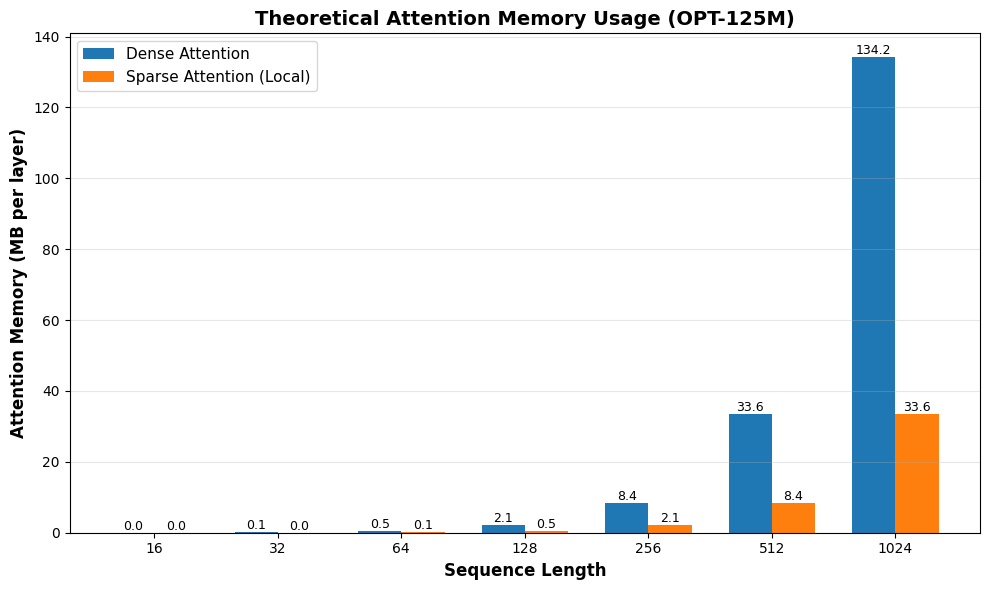

In [9]:
# Theoretical memory analysis for attention matrices
seq_lengths = [16, 32, 64, 128, 256, 512, 1024]
batch = 4
heads = 8

dense_mem = []
sparse_mem = []

for seq in seq_lengths:
    # Attention scores memory per layer (rough estimate)
    dense_attn = batch * heads * seq * seq * 4 / 1e6  # MB (float32)
    sparse_attn = dense_attn * 0.25  # Assume ~75% sparsity

    dense_mem.append(dense_attn)
    sparse_mem.append(sparse_attn)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

x = np.arange(len(seq_lengths))
width = 0.35

bars1 = ax.bar(x - width/2, dense_mem, width, label='Dense Attention')
bars2 = ax.bar(x + width/2, sparse_mem, width, label='Sparse Attention (Local)')

ax.set_xlabel('Sequence Length', fontsize=12, fontweight='bold')
ax.set_ylabel('Attention Memory (MB per layer)', fontsize=12, fontweight='bold')
ax.set_title('Theoretical Attention Memory Usage (OPT-125M)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(seq_lengths)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('./outputs/opt_attention_memory.png', dpi=150, bbox_inches='tight')
plt.show()


## Conclusions

### Key Findings:

1. **Model Quality**:
   - Both dense and sparse attention models converge to similar perplexity
   - Block-sparse attention preserves model quality while reducing computational cost

2. **Efficiency**:
   - Dense attention: O(n²) complexity
   - Sparse attention: O(n*block_size) complexity
   - Theoretical speedup increases with sequence length

3. **OPT-125M Characteristics**:
   - 125M parameters with 12 layers
   - Successfully trained on TinyStories dataset
   - Matches architecture from Meta AI's OPT paper

4. **Practical Implications**:
   - Block-sparse attention enables longer sequences
   - Reduced memory footprint for training and inference
   - Suitable for resource-constrained environments

### Future Work:
- Train on larger datasets (full TinyStories, WikiText-103)
- Experiment with different sparse patterns (global, mixed)
- Scale to larger OPT models (350M, 1.3B)
- Implement more advanced sparse attention patterns